In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "http://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()


In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
import matplotlib.pyplot as plt
IMAGE_PATH = Path() / "images"/ "end_to_end_project"
IMAGE_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGE_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

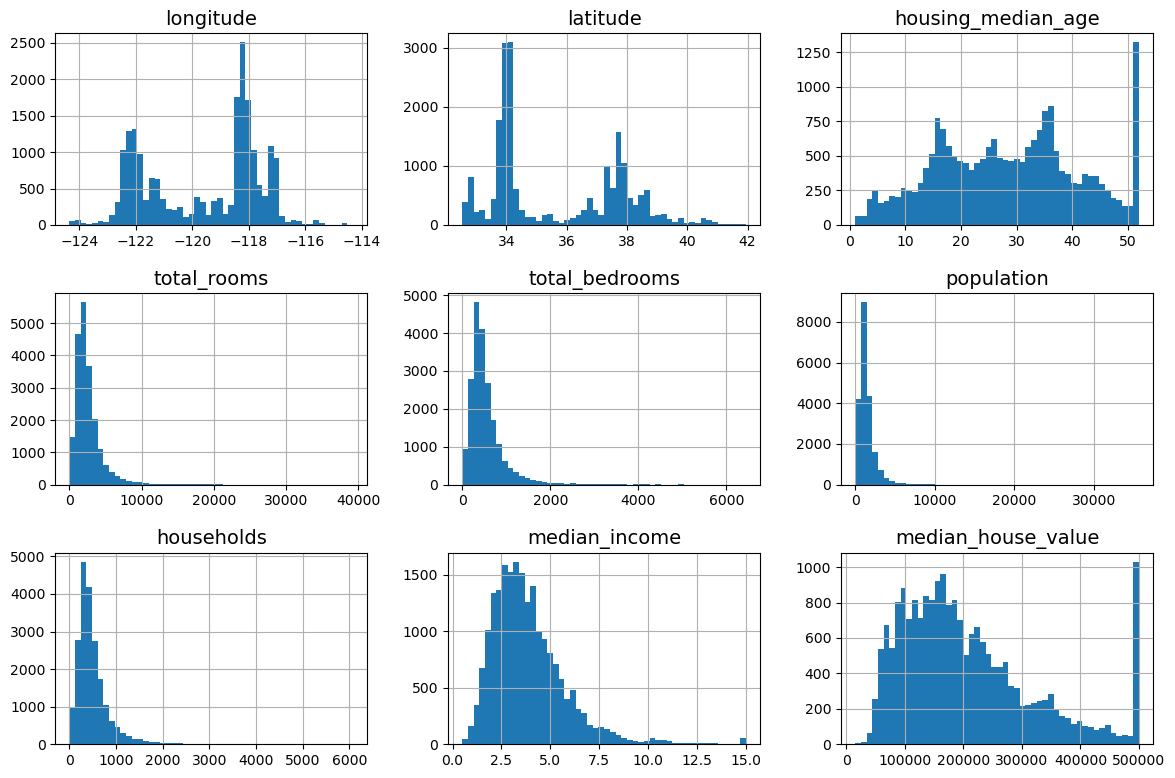

In [7]:
plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

housing.hist(bins=50, figsize=(12,8))
save_fig("attribute_histogram_plots")
plt.show()

In [9]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) *test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set , test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [11]:
len(test_set)

4128

In [12]:
np.random.seed(42)

In [13]:
from zlib import crc32

In [14]:
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio *2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids= data[id_column]
    in_test_set = ids.apply(lambda id_ : is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


In [15]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [25]:

housing_with_id["id"] = housing["longitude"]* 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [26]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

test_set["total_bedrooms"].isnull().sum()

44

In [27]:
from scipy.stats import binom

sample_size = 1000
ratio_female =  0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485-1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929942


In [28]:
samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)
((samples <485)  | (samples > 535)).mean()

0.1078

In [29]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0,4.5,6., np.inf],
                               labels=[1, 2,3,4,5])

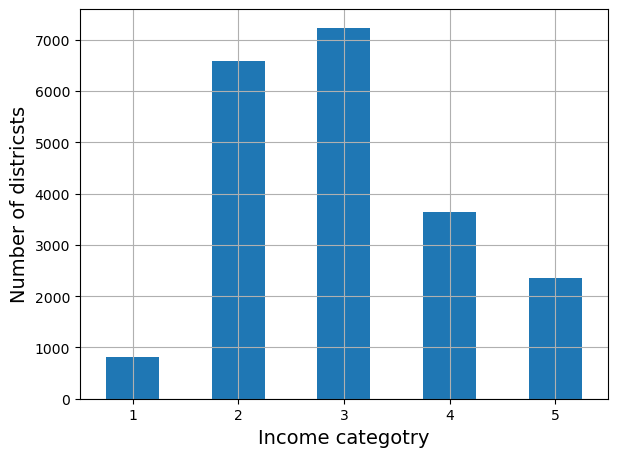

In [30]:
housing["income_cat"] .value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income categotry")
plt.ylabel("Number of districsts")
save_fig("housing_income_cat_bar_plot")
plt.show()

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit


splitter  = StratifiedShuffleSplit(n_splits= 10, test_size=0.2 , random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [32]:
strat_train_set, strat_test_set = strat_splits[0]

In [34]:

strat_train_set, strat_test_set  = train_test_split(housing, 
                                                    test_size=0.2,
                                                    stratify=housing["income_cat"],
                                                    random_state=42)

In [35]:
strat_test_set["income_cat"].value_counts()/ len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [36]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts()/ len(data)


train_set, test_set  = train_test_split(housing, test_size=0.2,
                                                    random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set)
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"]/
                                   compare_props["Overall %"] -1)
compare_props["Random. Error %"]= (compare_props["Random %"]/
                                   compare_props["Overall %"] -1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Random. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [37]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [38]:
housing = strat_test_set.copy()

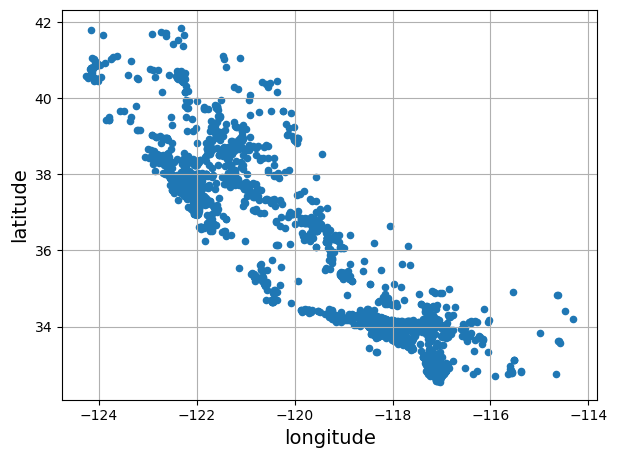

In [39]:
housing.plot(kind = "scatter", x= "longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")
plt.show()

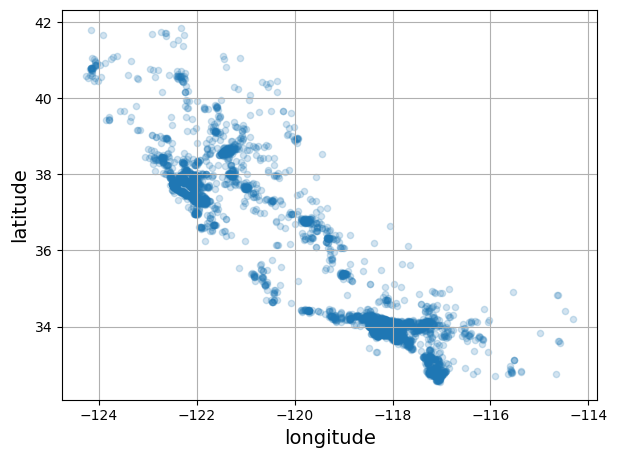

In [40]:
housing.plot(kind = "scatter", x= "longitude", y="latitude", grid=True, alpha=0.2)
save_fig("better_visualization_plot")
plt.show()

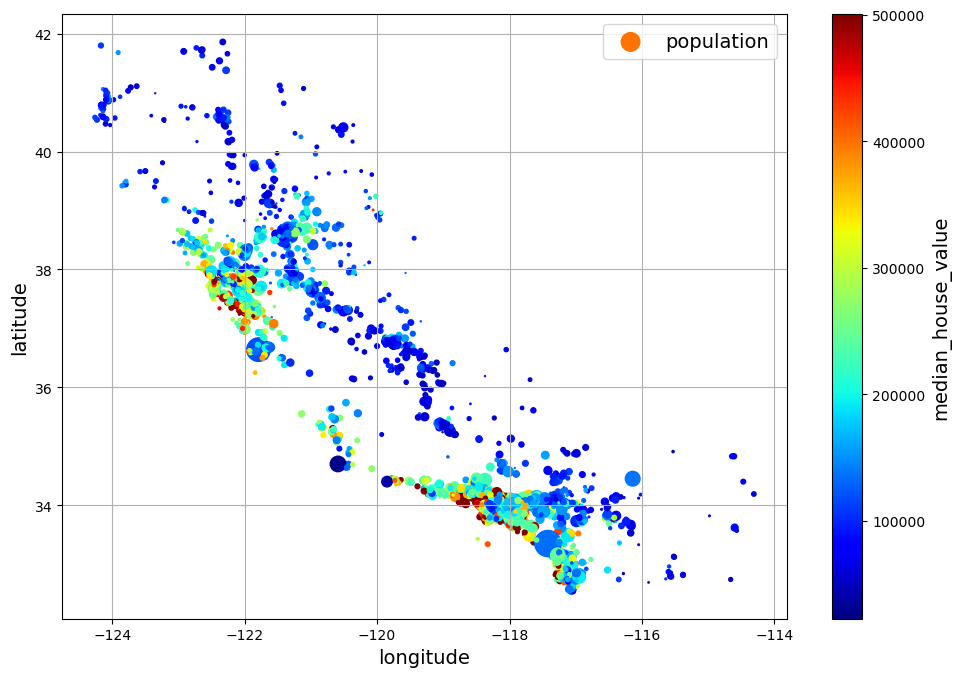

In [47]:
housing.plot(kind = "scatter", x= "longitude", y="latitude", grid=True,
             s=housing["population"]/100, label="population",
           c="median_house_value",
               cmap="jet", colorbar=True,
             legend=True, figsize=(10, 7))
save_fig("housing_prices_scatterplot")
plt.show()

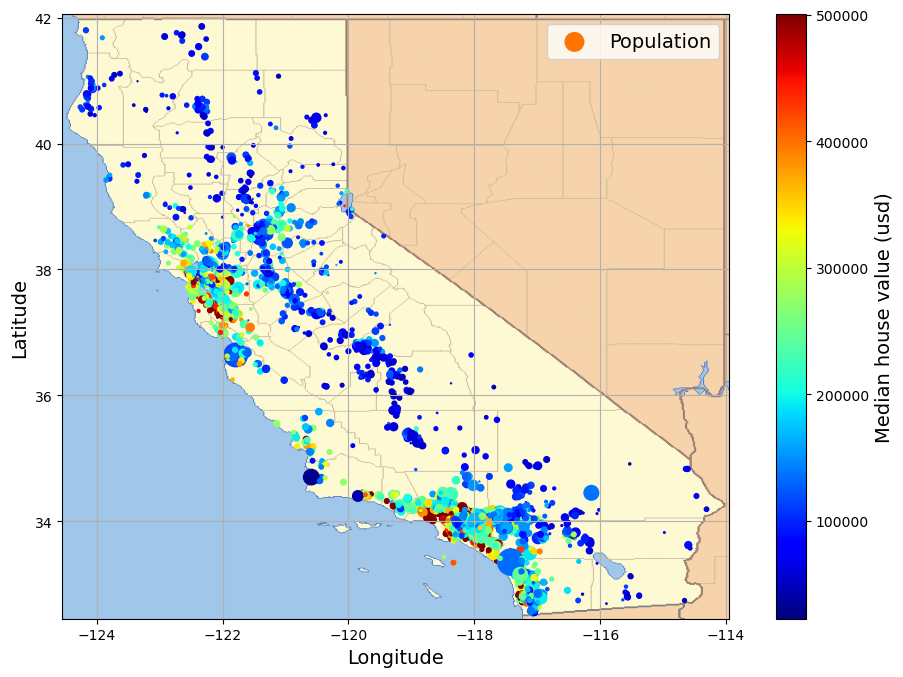

In [49]:
filename = "california.png"
if not (IMAGE_PATH/ filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGE_PATH/ filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
"population": "Population",
"median_house_value": "Median house value (usd)"
})
housing_renamed.plot(kind = "scatter", x= "Longitude", y="Latitude", grid=True,
             s=housing_renamed["Population"]/100, label="Population",
           c="Median house value (usd)",
               cmap="jet", colorbar=True,
             legend=True, figsize=(10, 7))

california_img = plt.imread(IMAGE_PATH/ filename)
axis= -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
save_fig("california_housing_prices_plot")
plt.show()

In [50]:
corr_matrix = housing.corr(numeric_only=True)

In [51]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687091
total_rooms           0.121070
housing_median_age    0.118976
households            0.043549
total_bedrooms        0.029600
longitude            -0.026768
population           -0.040286
latitude             -0.162087
Name: median_house_value, dtype: float64

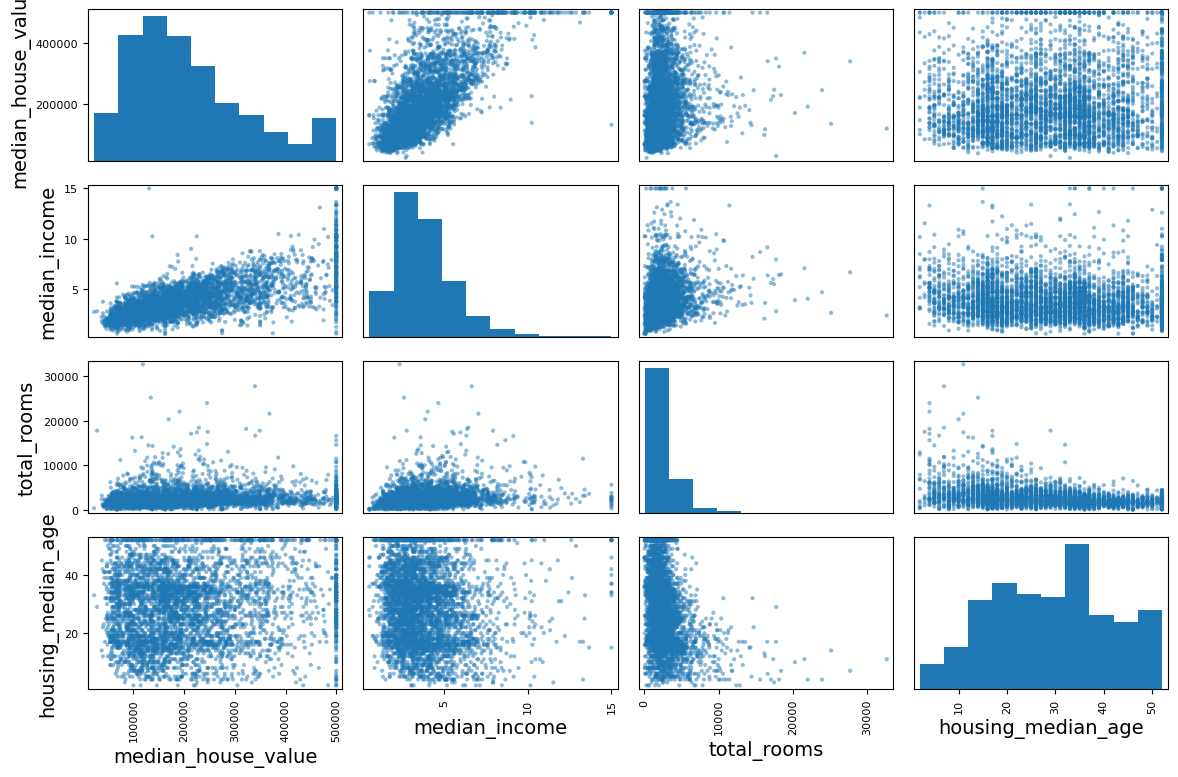

In [53]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")
plt.show()

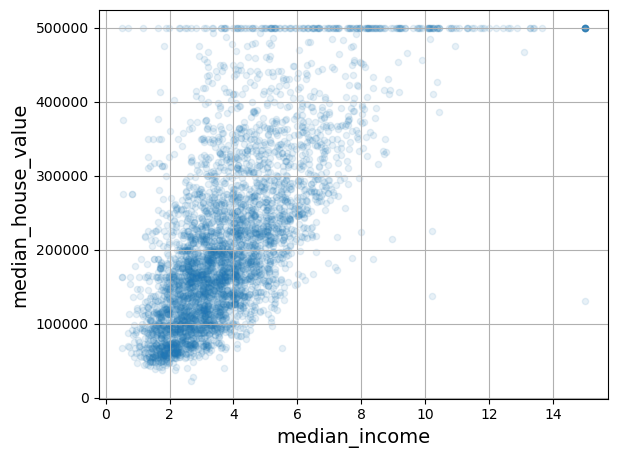

In [54]:
housing.plot(kind="scatter", x= "median_income", y= "median_house_value",
             alpha=0.1, grid=True)
save_fig("income_vs_house_value_scatterplot")
plt.show()

In [55]:
housing["rooms_per_house"] = housing["total_rooms"]/ housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"]/ housing["total_rooms"]
housing["people_per_house"] = housing["population"]/ housing["households"]

In [56]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687091
rooms_per_house       0.198322
total_rooms           0.121070
housing_median_age    0.118976
households            0.043549
total_bedrooms        0.029600
people_per_house     -0.025974
longitude            -0.026768
population           -0.040286
latitude             -0.162087
bedrooms_ratio       -0.254506
Name: median_house_value, dtype: float64

In [57]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [58]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [59]:
housing_option1 = housing.copy()
housing_option1.dropna(subset=["total_bedrooms"], inplace=True)
housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [60]:
housing_option2 = housing.copy()
housing_option2.drop("total_bedrooms", inplace=True, axis=1)
housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [61]:
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)

housing_option3.loc[null_rows_idx].head()

/tmp/ipykernel_1162/646133493.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing_option3["total_bedrooms"].fillna(median, inplace=True)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


In [62]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [63]:
housing_num = housing.select_dtypes(include=[np.number])

In [64]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [65]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [66]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [67]:
X = imputer.transform(housing_num)
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [69]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index= housing_num.index)
housing_tr.loc[null_rows_idx].head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020
17796,-118.31,34.03,47.0,1315.0,434.0,785.0,245.0,1.2300
4091,-122.41,38.16,37.0,1549.0,434.0,863.0,275.0,2.7457
16775,-118.30,33.72,35.0,2790.0,434.0,1167.0,441.0,6.2028
9827,-121.85,36.61,38.0,238.0,434.0,191.0,67.0,1.3897
19828,-122.08,37.39,4.0,2292.0,434.0,1050.0,584.0,4.8036


In [70]:
imputer.strategy

'median'

In [71]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [72]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

In [74]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [77]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [78]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [79]:
ordinal_encoder .categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [80]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [81]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [84]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [85]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [86]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [87]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [88]:
df_test_unknown =  pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "INLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_INLAND
0,True,False
1,False,True


In [89]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [90]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [91]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [92]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
 columns=cat_encoder.get_feature_names_out(), index=df_test_unknown.index)

In [93]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0


In [94]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
std_scaler = StandardScaler()
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

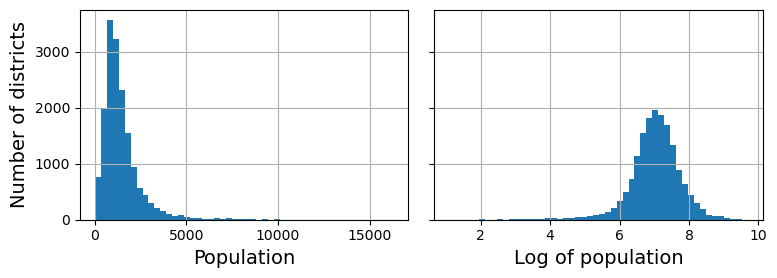

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(8,3), sharey=True)

housing["population"] .hist(ax=axs[0], bins=50)
housing["population"] .apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

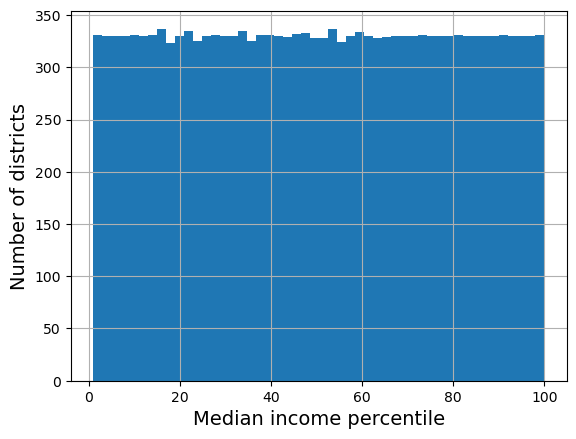

In [96]:
percentiles = [np.percentile(housing["median_income"], p)for p in range(1, 100)]
flattened_medain_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100+1))
flattened_medain_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()

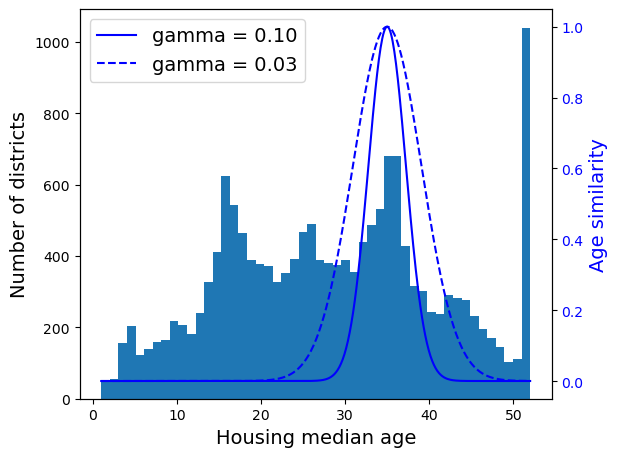

In [97]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(), 500).reshape(-1,1)

gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 =  rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()
color= "blue"

ax2.plot(ages, rbf1, color=color, label= "gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label= "gamma = 0.03", linestyle="--")
ax2.tick_params(axis="y", labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()

In [98]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())
model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [99]:
from sklearn.compose import TransformedTargetRegressor
model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

In [100]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["median_income"]])

In [101]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [103]:
sf_coords = 37.7749,-122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [104]:
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [105]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]]/ X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [106]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils .validation import check_array, check_is_fitted

In [107]:
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y= None):
        X = check_array(X)
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]
        return self
    
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X/ self.scale_
    

In [108]:
from sklearn.cluster import KMeans
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


In [109]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude","longitude"]],
                                           sample_weight=housing_labels)
similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

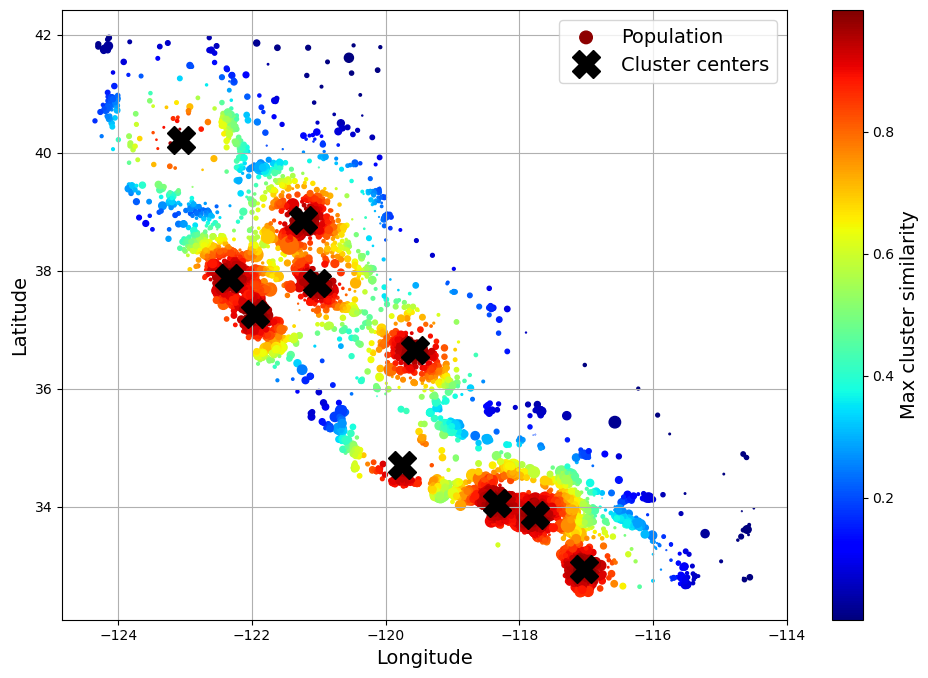

In [111]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
"population": "Population",
"median_house_value": "Median house value (usd)"
})
housing["Max cluster similarity"] = similarities.max(axis=1)
# housing_renamed.plot(kind = "scatter", x= "Longitude", y="Latitude", grid=True,
#              s=housing_renamed["Population"]/100, label="Population",
#             c="Max cluster similarity",
#                cmap="jet", colorbar=True,sharex=False,
#              legend=True, figsize=(10, 7))
housing_renamed.plot(kind = "scatter", x= "Longitude", y="Latitude", grid=True,
             s=housing_renamed["Population"]/100, label="Population",
            c="Max cluster similarity",
               cmap="jet", colorbar=True,sharex=False,
             legend=True, figsize=(10, 7))

plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:,0],
         linestyle="", color="black", marker="X", markersize=20,label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

In [112]:
from sklearn .pipeline import Pipeline
num_pipeline = Pipeline([("inpute", SimpleImputer(strategy="median")),
                         ("Standardize", StandardScaler())])

In [113]:
from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [115]:
from sklearn import set_config
set_config(display="diagram")
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [116]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [117]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index
)

In [118]:
df_housing_num_prepared.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


In [119]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [120]:
num_pipeline[1]

StandardScaler()

In [121]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [123]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [124]:
num_pipeline.set_params(simpleimputer__strategy = "median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [125]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude","housing_median_age", "total_rooms",
               "total_bedrooms", "population","households", "median_income"]
cat_attribs = ["ocear_proximity"]
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                             OneHotEncoder(handle_unknown="ignore"))
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])


In [126]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)
housing_prepared = preprocessing.fit_transform(housing)

In [127]:
housing_prepared_fr = pd.DataFrame(housing_prepared,
                                   columns=preprocessing.get_feature_names_out(),
                                   index=housing.index)
housing_prepared_fr .head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-1__Max cluster similarity,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.665916,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,0.682175,1.0,0.0,0.0,0.0,0.0


In [128]:
def column_ratio(X):
    return X[:, [0]]/ X[:, [1]]
def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

In [129]:
def ratio_pipeline():
    return make_pipeline(SimpleImputer(strategy="median"),
                         FunctionTransformer(column_ratio, feature_names_out=ratio_name),
                         StandardScaler())

In [130]:
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

In [132]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [133]:
preprocessing = ColumnTransformer([
("bedrooms", ratio_pipeline(),["total_bedrooms", "total_rooms"]),
("rooms_per_house", ratio_pipeline(),["total_rooms", "households"]),
("people_per_house", ratio_pipeline(),["population", "households"]),
("log", log_pipeline,["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
("geo", cluster_simil,["latitude", "longitude"]),
("cat", cat_pipeline ,make_column_selector(dtype_include=object)),
], remainder=default_num_pipeline)

In [134]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 25)

In [135]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age',
       'remainder__Max cluster similarity'], dtype=object)

In [136]:
from sklearn.linear_model import LinearRegression
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f6...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f604af4cfd0>)])),
                ('linearregression', LinearRegression())])

In [137]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

array([252300., 380000., 109100.,  84800., 307100.])

In [138]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [139]:
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100*ratio: .1f}%" for ratio in error_ratios]))

-44.9%, -21.5%,  7.3%, -11.8%, -15.1%


In [143]:
from sklearn .metrics import mean_squared_error, root_mean_squared_error

# lin_rmse = mean_squared_error(housing_labels, housing_predictions,
#                               squared=False)
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

67518.67622054463

In [144]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f6...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f604af4cfd0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [145]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

In [146]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()


count       10.000000
mean     66790.331389
std       2141.905449
min      63687.967454
25%      65472.716186
50%      66468.322405
75%      68017.971659
max      70782.518512
dtype: float64

In [147]:
lin_rmses =  -cross_val_score(lin_reg, housing, housing_labels, 
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     68565.291989
std       3755.970265
min      64558.433405
25%      67055.131179
50%      67305.855285
75%      68592.525211
max      78475.688244
dtype: float64

In [148]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, 
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, 
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     46718.811136
std       1102.419808
min      45268.673376
25%      46143.249382
50%      46735.144148
75%      46978.365627
max      49199.273825
dtype: float64

In [149]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions)
forest_rmse

17475.60981915357

In [151]:
from sklearn.model_selection import GridSearchCV
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42))
])
param_grid = [
    {"preprocessing__geo__n_clusters": [5,8,10],
    "random_forest__max_features": [4,6,8]},
    {"preprocessing__geo__n_clusters": [10,15],
     "random_forest__max_features": [6,8,10]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring="neg_root_mean_squared_error")
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f604af4cfd0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [152]:
print(str(full_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__force_int_remainder_cols', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__keep_empty_features', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'prepro

In [153]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [154]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f604b0...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f604acb6510>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [155]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)


cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols

cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43034,43645,44530,43736
13,15,8,43492,43769,44626,43962
14,15,10,43884,44112,44833,44276
7,10,6,43754,44512,45464,44577
9,10,6,43754,44512,45464,44577


In [159]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, RandomizedSearchCV
from scipy.stats import randint

param_distribs = {"preprocessing__geo__n_clusters": randint(low=3, high=50),
                  "random_forest__max_features": randint(low=2, high=20)}

rnd_search=  RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring="neg_root_mean_squared_error", random_state=42
)
rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f602c1bce50>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f601bf2d090>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [160]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)


cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", 
                 "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols

cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,40968,42214,42656,41946
8,32,7,41406,42443,43194,42348
5,42,4,41636,42997,43700,42777
2,23,8,42082,42887,43639,42869
0,41,16,42362,43141,43362,42955


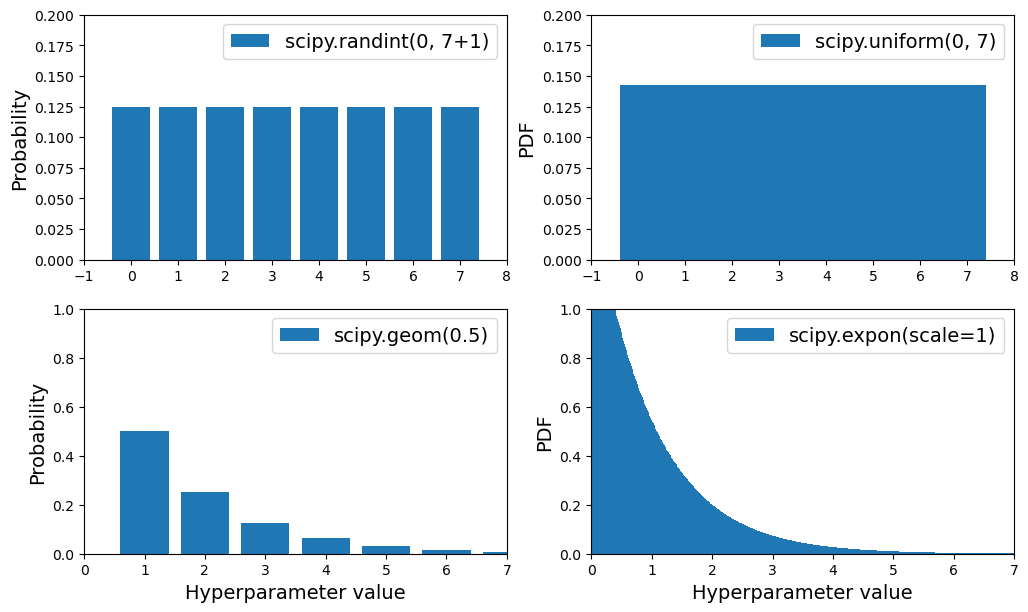

In [161]:
from scipy.stats import randint , uniform , geom , expon
xs1=  np.arange(0, 7+1)

randint_distrib = randint(0, 7+1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 +1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2,2,1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7+1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8,0,0.2])

plt.subplot(2,2,2)
plt.bar(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8,0,0.2])


plt.subplot(2,2,3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0,7,0,1])


plt.subplot(2,2,4)
plt.bar(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0 ,7,0,1])
plt.show()